In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

## Downloading the dataset

In [3]:
# ! wget --header="Host: pjreddie.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.117 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: __utmc=134107727; __utma=134107727.1113873570.1524510765.1524510765.1525057229.2; __utmz=134107727.1525057229.2.2.utmcsr=localhost:9000|utmccn=(referral)|utmcmd=referral|utmcct=/notebooks/Project/pascal.ipynb; __utmt=1; __utmb=134107727.1.10.1525057229" --header="Connection: keep-alive" "https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar" -O "VOCtrainval_06-Nov-2007.tar" -c
# ! wget --header="Host: pjreddie.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.117 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: __utmc=134107727; __utma=134107727.1113873570.1524510765.1524510765.1525057229.2; __utmz=134107727.1525057229.2.2.utmcsr=localhost:9000|utmccn=(referral)|utmcmd=referral|utmcct=/notebooks/Project/pascal.ipynb; __utmt=1; __utmb=134107727.1.10.1525057229" --header="Connection: keep-alive" "https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar" -O "VOCtest_06-Nov-2007.tar" -c
# ! tar -xvf data/VOCtrainval_06-Nov-2007.tar
# ! tar -xvf data/VOCtest_06-Nov-2007.tar
# ! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.117 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip" -O "PASCAL_VOC.zip" -c


In [4]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/tmp'),
 PosixPath('data/PASCAL_VOC/VOCdevkit'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/models'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. 

In [5]:
train_json = json.load((PATH/'pascal_train2007.json').open())
train_json.keys()

# trn_j = json.load((PATH/'pascal_train2007.json').open())
# trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
train_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [7]:
train_json[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

In [8]:
train_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

Taking all the things we needs: image name, image id, id, category id, bounding box

In [9]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {cat[ID]:cat['name'] for cat in train_json[CATEGORIES]}
train_file_name = {im[ID]:im[FILE_NAME] for im in train_json[IMAGES]}
train_ids = [im[ID] for im in train_json[IMAGES]]

In [10]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
print(list(IMG_PATH.iterdir())[:5])
img0 = train_json[IMAGES][11]
img0[FILE_NAME], img0[ID], img0['height'], img0['width']

[PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007594.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005866.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007013.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005682.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/000080.jpg')]


('000047.jpg', 47, 333, 500)

In [11]:
[{ann[IMG_ID]:[ann[BBOX]]} for ann in train_json[ANNOTATIONS] if ann[IMG_ID]==47][0]

{47: [[14, 0, 445, 312]]}

Here the first 2 represent the x,y coordinates of the top left corner, while the 3rd represents the width (14 + 445) and the 4th represents the height (0 + 312). Thus (14 + 445), (0 + 312) give the x,y coordinates of the bottom right.

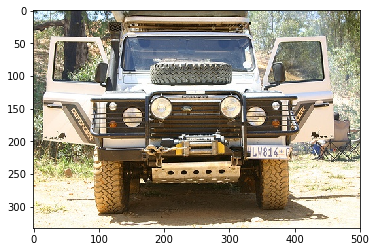

In [12]:
plt.imshow(open_image(IMG_PATH/img0[FILE_NAME]))

Thus, each image has a unique ID. And every image id corresponds to the image name.

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here I create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [13]:
def top_left_bottom_right(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [14]:
train_anno = collections.defaultdict(lambda:[])
for ann in train_json[ANNOTATIONS]:
    if not ann['ignore']:
        bb = ann[BBOX]
        bb = top_left_bottom_right(bb)
        train_anno[ann[IMG_ID]].append((bb, ann[CAT_ID]))

print(len(train_anno))
train_anno[img0[ID]]                   

2501


[(array([  0,  14, 311, 458]), 7), (array([169, 438, 229, 486]), 9)]

In [15]:
cats[15]

'person'

In [16]:
bb_voc = [155, 96, 196, 174]
bb_new = top_left_bottom_right(bb_voc)
def bb_original(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
f'expected: {bb_voc}, actual: {bb_original(bb_new)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [17]:
im = open_image(IMG_PATH/img0[FILE_NAME])


In [18]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

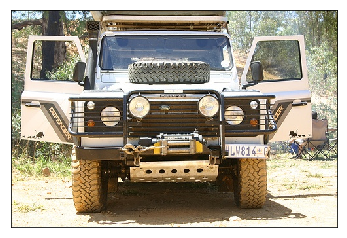

In [19]:
show_img(im)

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [20]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [21]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [22]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [23]:
train_anno[img0[ID]][0][1]

7

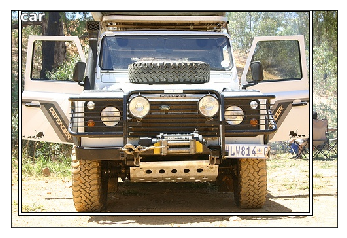

In [24]:
ax = show_img(im)
b = bb_original(train_anno[img0[ID]][0][0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[train_anno[img0[ID]][0][1]])

In [25]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_original(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [26]:
def draw_idx(i):
    im_a = train_anno[i]
    im = open_image(IMG_PATH/train_file_name[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


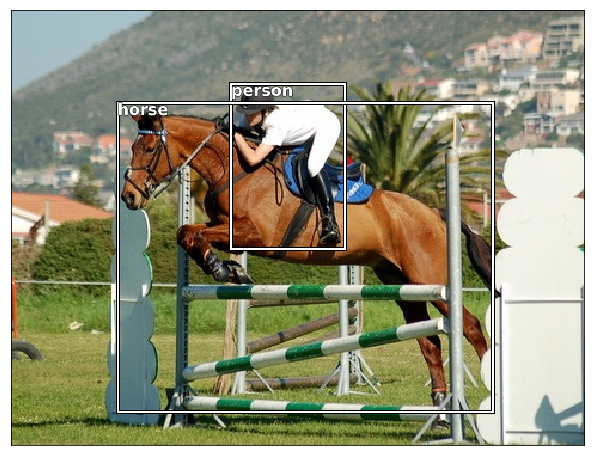

In [27]:
draw_idx(17)

## Largest item classifier

In [28]:
def get_largest(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [29]:
train_largest_anno = {a: get_largest(b) for a,b in train_anno.items()}

Now we have a dictionary from image id to a single bounding box - the largest for that image.

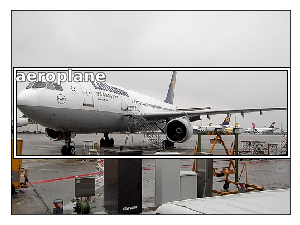

In [30]:
b,c = train_largest_anno[33]
b = bb_original(b)
ax = show_img(open_image(IMG_PATH/train_file_name[33]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [31]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/large.csv'

In [32]:
df = pd.DataFrame({'fn': [train_file_name[ti] for ti in train_ids],
    'cat': [cats[train_largest_anno[ti][1]] for ti in train_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

## Training the model for object detection

In [33]:
f_model = resnet34
sz=224
bs=64

In [34]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [35]:
?? tfms_from_model

In [36]:
x,y=next(iter(md.val_dl))

In [37]:
y.shape

torch.Size([64])

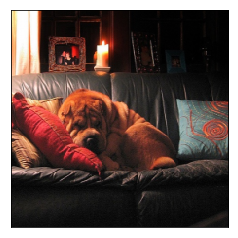

In [38]:
show_img(md.val_ds.denorm(to_np(x))[1]);

In [40]:
?? ConvnetBuilder

In [41]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [148]:
learn.children[4]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [42]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s, loss=20.1]

When you LR finder graph looks like this, you can ask for more points on each end:

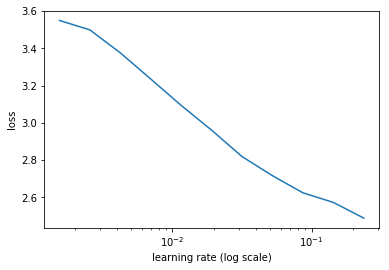

In [43]:
learn.sched.plot()

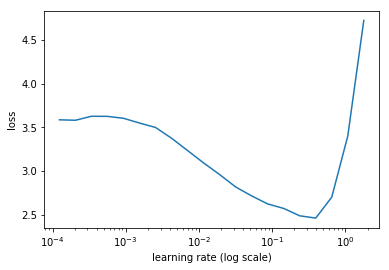

In [45]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [46]:
lr = 2e-2

In [47]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 21/32 [00:08<00:04,  2.55it/s, loss=1.53]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.320805   0.689358   0.786     



[array([0.68936]), 0.7860000028610229]

In [48]:
lrs = np.array([lr/1000,lr/100,lr])

In [55]:
?? learn.models.get_layer_groups

In [54]:
learn.freeze_to(-2)

<bound method ConvnetBuilder.get_layer_groups of <fastai.conv_learner.ConvnetBuilder object at 0x7f153c2d95f8>>

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                    


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 84%|████████▍ | 27/32 [00:17<00:03,  1.55it/s, loss=4.07] 


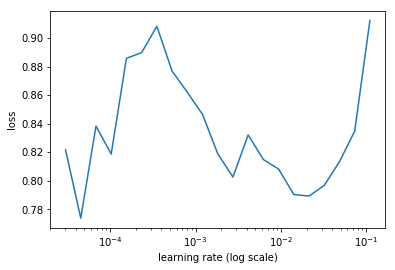

In [56]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [57]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.80904    0.603836   0.806     



[array([0.60384]), 0.8059999976158142]

In [58]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [59]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.605019   0.565883   0.824     
    1      0.437347   0.565445   0.84                      



[array([0.56545]), 0.8399999990463257]

In [60]:
learn.save('clas_one')

In [61]:
learn.load('clas_one')

In [62]:
?? to_np

In [63]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

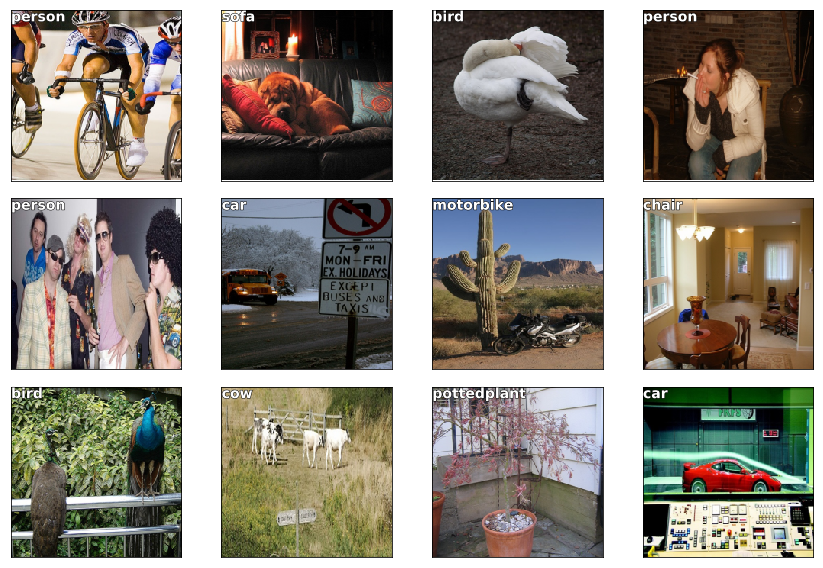

In [64]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [65]:
BB_CSV = PATH/'tmp/bb.csv'

In [70]:
bb = np.array([train_largest_anno[ti][0] for ti in train_ids])
bbs = [' '.join(str(p) for p in b) for b in bb]

df = pd.DataFrame({'fn': [train_file_name[ti] for ti in train_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [71]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [72]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [73]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [74]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]
[ 64.  38. 395. 308.]


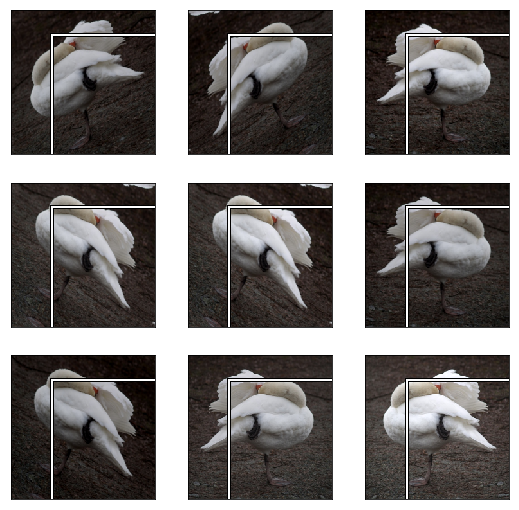

In [77]:
idx=2
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_original(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [78]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [79]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 10.   3. 194. 219.]
[ 13.  11. 188. 207.]
[ 20.  23. 174. 181.]
[ 16.  16. 182. 196.]
[ 20.  23. 174. 181.]
[ 20.  23. 174. 181.]
[ 25.  15. 183. 196.]
[ 11.   7. 192. 215.]
[ 26.  16. 181. 194.]


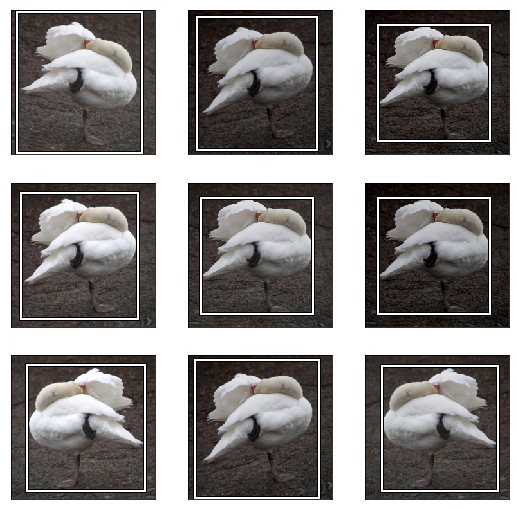

In [81]:
idx=2
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_original(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [82]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [83]:
512*7*7

25088

In [84]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [85]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s, loss=450] 

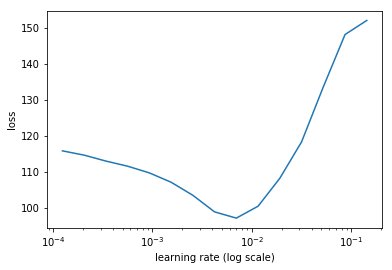

In [86]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [87]:
lr = 2e-3

In [88]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 50%|█████     | 16/32 [00:08<00:08,  1.99it/s, loss=65.5]


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      48.332987  34.037866 
    1      37.43525   28.467384                           
    2      31.540006  27.780237                           



[array([27.78024])]

In [89]:
lrs = np.array([lr/100,lr/10,lr])

In [90]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      72.022945  59231154573672.445



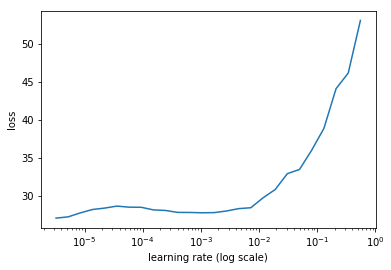

In [91]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [92]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.963521  22.883677 
    1      22.651795  21.700885                           
    2      19.504692  19.69238                            



[array([19.69238])]

In [93]:
learn.freeze_to(-3)

In [94]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      18.305766  21.50437  
    1      16.375064  19.808566                           



[array([19.80857])]

In [95]:
learn.save('reg4')

In [96]:
learn.load('reg4')

In [108]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

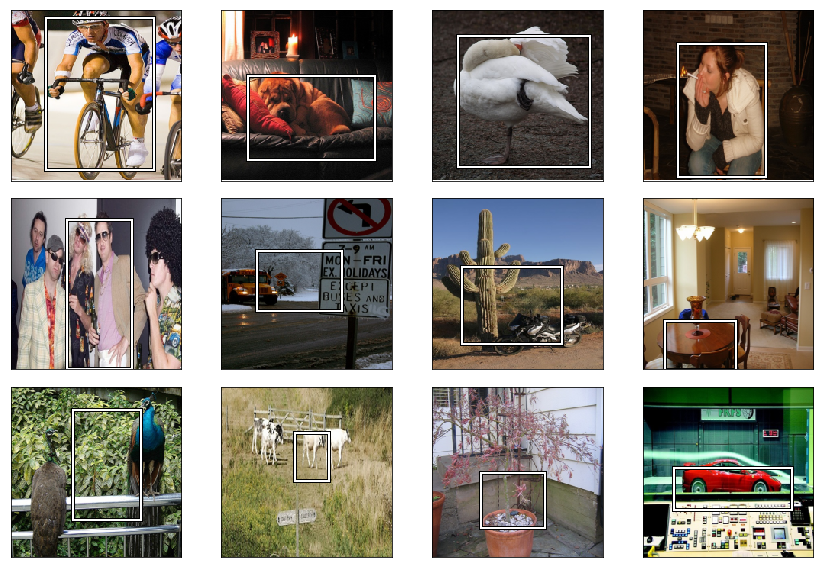

In [109]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_original(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [111]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(train_file_name))

In [112]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [113]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [114]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [115]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [116]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [117]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [118]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_original(to_np(y[0][idx])); b

array([ 52.,  38., 107., 185.])

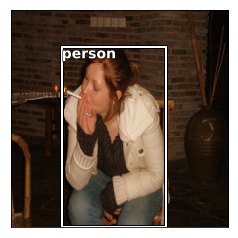

In [121]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [122]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [123]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s, loss=961]

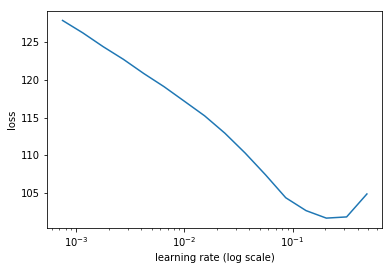

In [124]:
learn.lr_find()
learn.sched.plot()

In [125]:
lr=1e-2

In [126]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                   


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      74.151371  44.792696  0.798      31.933154 
    1      53.283681  36.122834  0.818      25.494863     
    2      43.401649  35.12677   0.816      24.45937      



[array([35.12677]), 0.8160000009536743, 24.45936961364746]

In [127]:
learn.save('reg1_0')

In [128]:
learn.freeze_to(-2)

In [129]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:19<00:02,  1.48it/s, loss=200] 

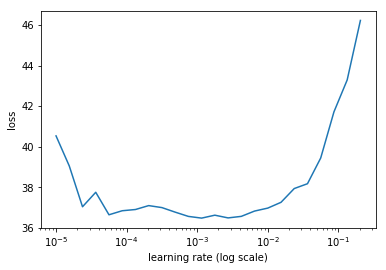

In [130]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [131]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

 34%|███▍      | 11/32 [00:09<00:17,  1.21it/s, loss=36.3]


Exception in thread Thread-30:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      36.964871  36.453841  0.802      24.069785 
    1      32.141916  33.060768  0.828      20.9698       
    2      27.778944  32.101381  0.816      20.39686      
    3      24.305025  31.399886  0.814      19.468241     
    4      21.689105  30.989649  0.816      19.302537     



[array([30.98965]), 0.8160000014305114, 19.302537307739257]

In [132]:
learn.save('reg1_1')

In [133]:
learn.load('reg1_1')

In [134]:
learn.unfreeze()

In [135]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      18.957869  31.43258   0.814      19.322118 
    1      18.5491    31.65342   0.812      19.388996     
    2      17.534054  31.336225  0.822      19.082428     
    3      16.860898  30.070246  0.832      18.342679     
    4      15.985486  31.26967   0.808      18.580712     
    5      15.291025  30.877293  0.81       18.363604     
    6      14.35957   31.110127  0.816      18.199442     
    7      13.695485  30.518958  0.82       18.243259     
    8      13.186967  30.05493   0.818      17.977238     
    9      12.803055  29.890202  0.82       17.933126     



[array([29.8902]), 0.8200000028610229, 17.933125633239747]

In [136]:
learn.save('reg1')

In [137]:
learn.load('reg1')

In [138]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [139]:
from scipy.special import expit

In [141]:
?? expit

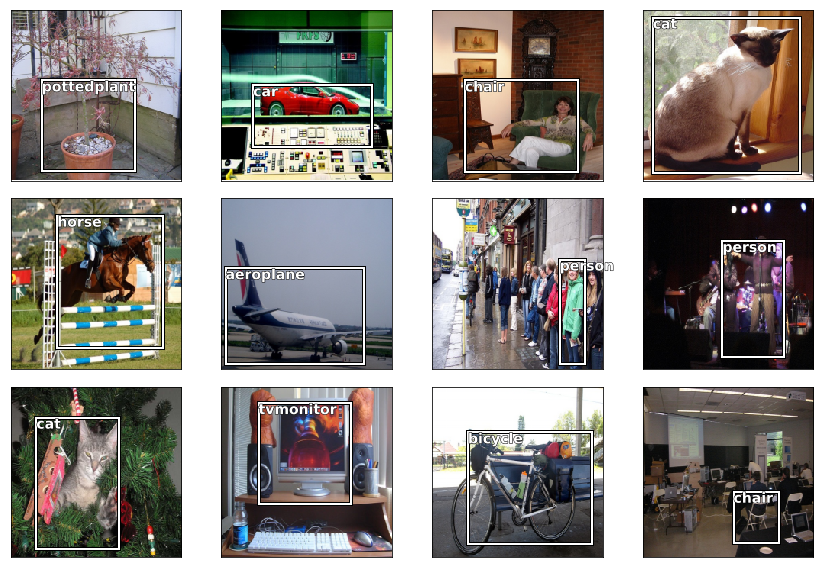

In [144]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i+10]
    bb = expit(y[i+10][:4])*224
    b = bb_original(bb)
    c = np.argmax(y[i+10][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()